In [1]:
import math

import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

import setup_modules
from lib.preprocessing import process, load_stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
stemmer = PorterStemmer()

In [3]:
tdf_g = pd.read_csv('working-csvs/fomc_sectioned_speaker_grouped.csv', index_col=0)

In [4]:
tdf_g

,date,speaker,text_enhanced
0,1994-02-04,CHAIRMAN GREENSPAN.,"I want to note that revisions, if any, on the ..."
1,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development..."
2,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...
3,1994-02-04,MR. FORRESTAL.,"Well, the moderate expansion that we've been e..."
4,1994-02-04,MR. HOENIG.,"Mr. Chairman, our District continues to grow a..."
...,...,...,...
3436,2018-12-19,MR. ROSENGREN.,Thank you very much for the presentation highl...
3437,2018-12-19,MS. BOWMAN.,"Thank you, Mr. Chairman. As many have already..."
3438,2018-12-19,MS. BRAINARD.,"Thank you. Like many of you, I see a disconne..."
3439,2018-12-19,MS. GEORGE.,All right. I'm going to drop any literary ref...


In [6]:
stopwords = load_stopwords('./stopwords/stopwords.txt')

In [7]:
tdf_g['tokens'] = tdf_g['text_enhanced'].apply(lambda x : process(x, stemmer=stemmer, stopwords=stopwords)) 

In [8]:
texts = tdf_g['tokens'].tolist()

In [9]:
dictionary = Dictionary().load('./models/02-27/02-27dict')

In [10]:
len(dictionary)

8823

In [11]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [56]:
K = 30
ldamodel = LdaModel(corpus, num_topics=K, id2word=dictionary, passes=10, random_state=0, minimum_probability=0, eta=0.025, alpha=50/K)

In [60]:
ldamodel.save('./models/02-27/02-27lda')


In [4]:
ldamodel = LdaModel.load('models/12-10lda')

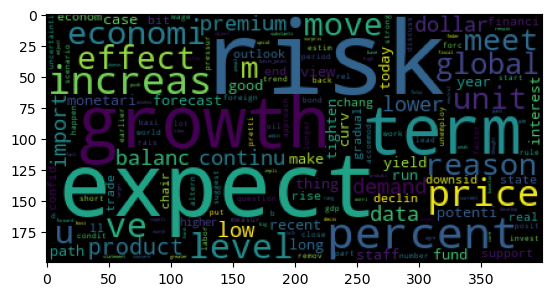

In [36]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(22, 200))))

In [57]:
wordprobs = np.array([[round(prob,2) for word, prob in ldamodel.show_topic(i, topn=12)] for i in range(K)])
words = np.array([[word for word, prob in ldamodel.show_topic(i, topn=12)] for i in range(K)])

In [58]:
topic_labels = [f'Topic {i}' for i in range(K)]

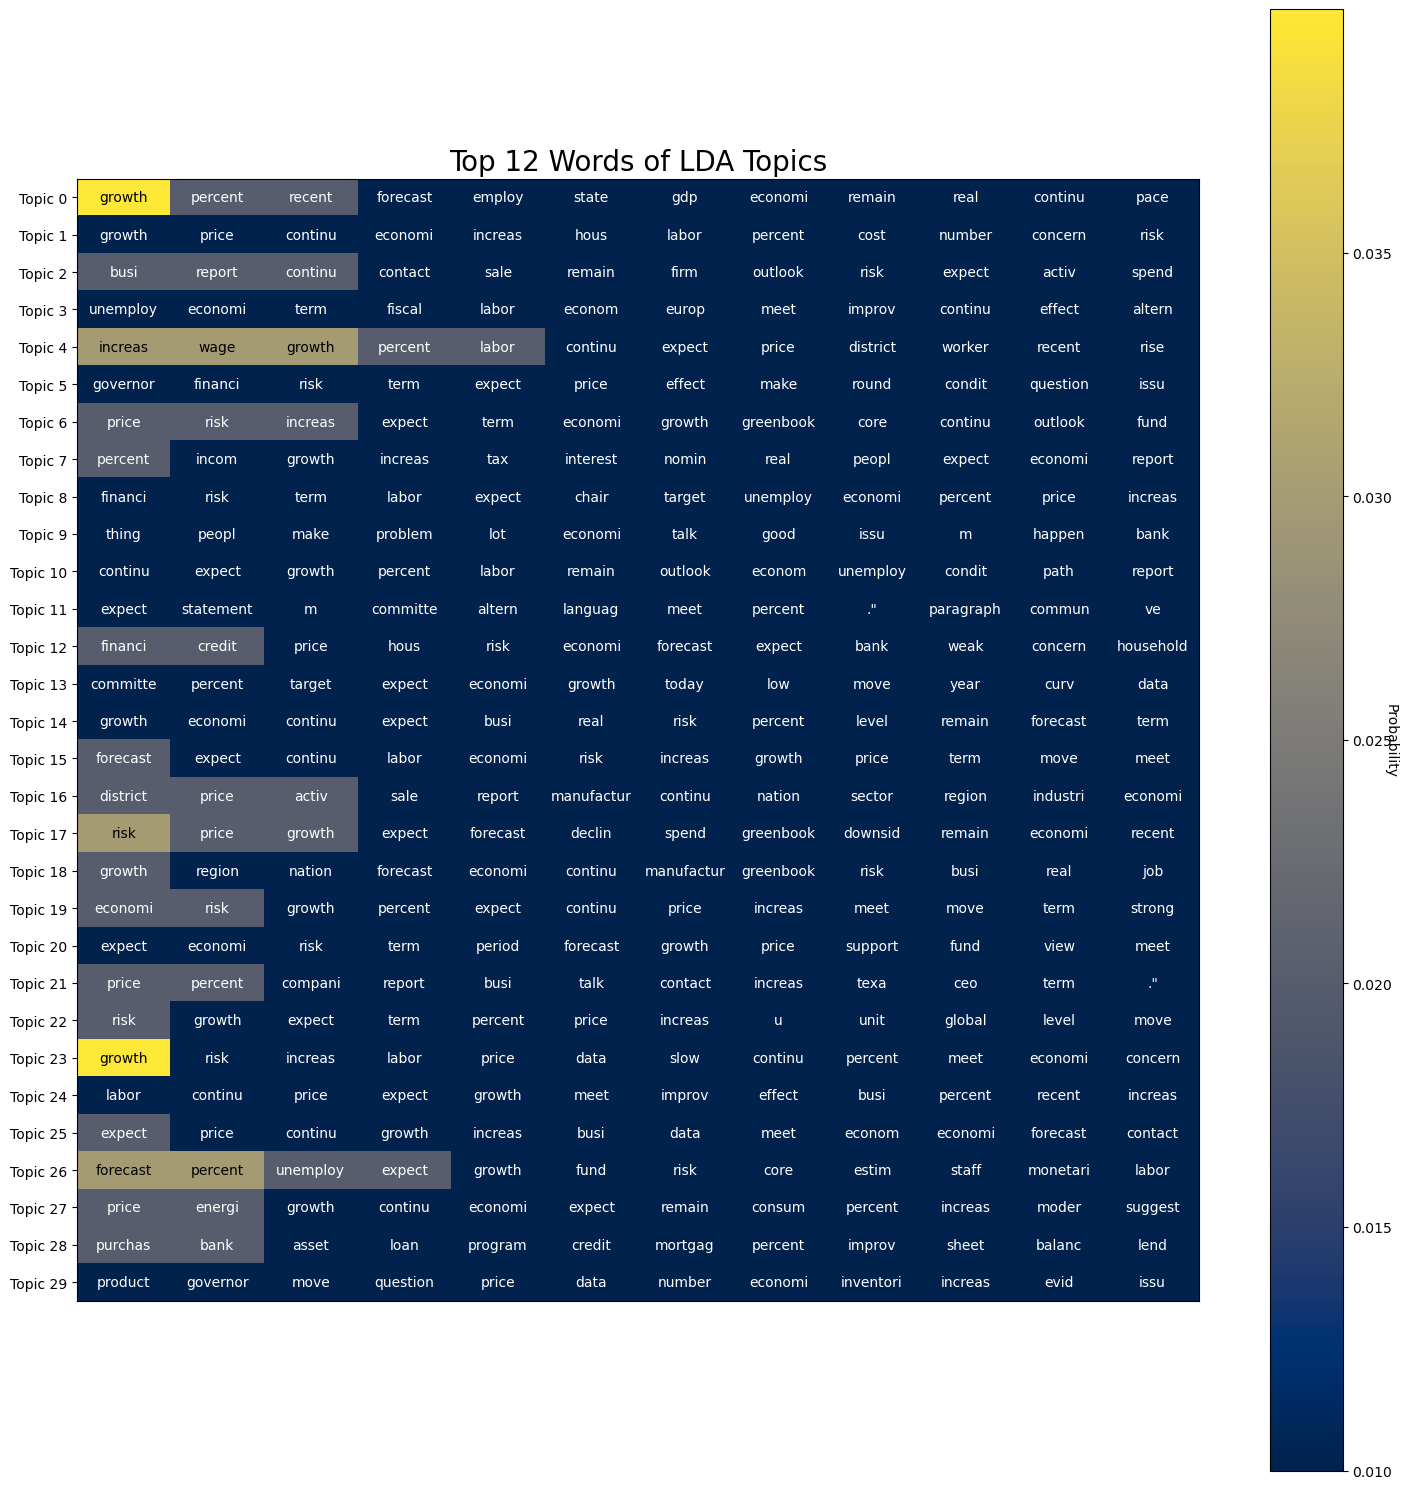

In [59]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(wordprobs, aspect='0.4', cmap='cividis')

ax.set_title('Top 12 Words of LDA Topics', fontsize=20 )

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Probability', rotation=-90)

ax.set_yticks(np.arange(K), labels=topic_labels)
ax.set_xticks([])

textcolors=('white', 'black')

for i in range(K):
    for j in range(12):
        text = ax.text(j, i, words[i, j], ha='center', va='center', color=textcolors[int(im.norm(wordprobs[i,j]) > 0.4)])

fig.tight_layout()

print()

In [17]:
def get_all_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    result = [0] * K
    for topic, prob in topic_probs:
        result[topic] = prob
    return pd.Series(result)

In [18]:
tdf_g[[f'tprob_{i}' for i in range(K)]] = tdf_g.tokens.apply(get_all_topics)

In [ ]:
tdf_g

In [ ]:
tdf_g['tokens']

EVENTUALLY FIX THIS TO ONLY INCLUDE WORDS NOT PRUNED BY TF-IDF

In [19]:
tdf_g['len'] = tdf_g['tokens'].apply(len)

In [20]:
tdf_g.to_csv('working-csvs/grouped_w_topics.csv')